## Tutorial : Automatically determining TF binding site locations

The code in this tutorial is released under the [MIT License](https://opensource.org/licenses/MIT). All the content in this notebook is under a [CC-by 4.0 License](https://creativecommons.org/licenses/by/4.0/). 

Created by Bill Ireland, Suzy Beleer and Manu Flores. 

In [1]:
#Import basic stuff
#from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

#import the custom analysis software
import scipy as sp
import seaborn as sns
import viz

# Set PBoC plotting style 
viz.pboc_style_mpl()

# Setting the inside the notebook
%matplotlib inline
# Get svg graphics from the notebook
%config InlineBackend.figure_format = 'svg' 

To determine locations of binding sites automatically, we must take the information footprints and expression shift plots and determine which ones are truly part of binding sites. To do this we will first determine which base pairs have a signficant inpact on gene expression. Then if there are 5 or more significant base pairs within a 15 base pair region, then we tentatively classify that area as a binding site. These areas need to be reviewed by hand.

To do this, we will use the MCMC sampling done when inferring the expression shift to determine the uncertainty in each measurement.

First we will load in the MCMC samples

In [2]:
path = '../datasets/'

In [3]:
genelabel = 'aphA'
MCMC_samples = np.load(path + 'aphAheat_database.npy')
#remove burnin samples
MCMC_burnin = MCMC_samples[1000:,:]
parameter_to_check = 0

We can then look at the distributions of the MCMC samples for a given parameter. We can then construct a confidence interval for the parameter.

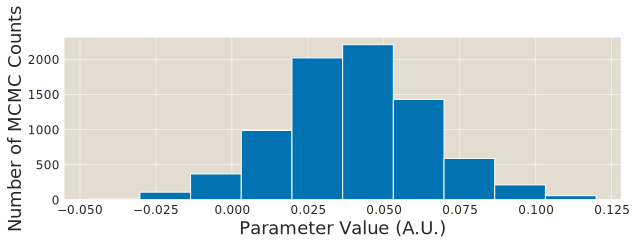

In [14]:
fig,ax = plt.subplots(figsize=(10,3))
plt.hist(MCMC_burnin[:,parameter_to_check])
ax.set_ylabel('Number of MCMC Counts')
ax.set_xlabel('Parameter Value (A.U.)')
plt.show()

The confidence interval is then

In [5]:
mean_value = np.mean(MCMC_burnin[:,parameter_to_check],axis=0)

#To determine statistical significance, if the mean value is greater than zero, we will check
#if five percent or more samples are less than zero.
if mean_value > 0:
    CI = np.percentile(MCMC_burnin[:,parameter_to_check],[5,100])
else:
    CI = np.percentile(MCMC_burnin[:,parameter_to_check],[0,95])

In [6]:
print(CI)

[0.00015512 0.11985067]


We see that 0 is within the conficent interval, so it does not have a significant effect on expression. We then determine similar information for each base pair.

In [7]:
all_significance = np.zeros((160))
for i in range(160):
    mean_value = np.mean(MCMC_burnin[:,i],axis=0)
    if mean_value > 0:
        CI = np.percentile(MCMC_burnin[:,i],[5,100])
    else:
        CI = np.percentile(MCMC_burnin[:,i],[0,95])
    #we now check if 0 in the confidence interval. If it is not, we label the base pair location as '1'.
    if 0 > CI[0] and 0 < CI[1]:
        all_significance[i] = False
    else:
        all_significance[i] = True

We will plot the results with significant base pair in red.

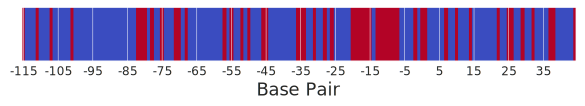

In [11]:
fig,ax = plt.subplots(figsize=(10,1))
plt.imshow(all_significance[np.newaxis,:],aspect='auto',cmap='coolwarm')
plt.yticks([])
ax.set_xlabel('Base Pair')
ax.set_xticks(np.arange(0,160,10))
ax.set_xticklabels(np.arange(-115,45,10))
plt.show()

We then check if there are 5 or more significant base pairs in a 15 base pair region. If so, we will declare it part of a binding site.

In [12]:
# we are looking at 15 base pair windows so we only need 145 entries.
TF_locations = np.zeros(145)

for i in range(145):
    if all_significance[i:i+15].sum() > 4:
        TF_locations[i] = True
    else:
        TF_locations[i] = False

Now we can plot the final results.

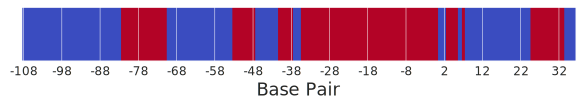

In [13]:
fig,ax = plt.subplots(figsize=(10,1))
plt.imshow(TF_locations[np.newaxis,:],aspect='auto',cmap='coolwarm')
plt.yticks([])
ax.set_xlabel('Base Pair')
ax.set_xticks(np.arange(0,145,10))
ax.set_xticklabels(np.arange(-108,38,10))
plt.show()

We see that there are multiple locations identified by this method. We can see regions from -82 to -70, -53 to -47, -41 to -37, -33 to to 1, 3 to 8, and 25 to 34. The region from -82 to -70 corresponds to a confirmed DeoR binding site and the -53 to -47 binding region corresponds to a part of a known FNR binding site. All regulatory regions from -41 to 1 correspond to an RNAP binding site. 

However, the downstream regions are unlikely to correspond to true TF binding sites.